## <b>Solving axisymmetric magnetostatic problem via Phycisc Informed Neural Networks (PINNs)<b>

This notebook gives an example of how to solve axisymmetric magnetostatic problem via Phycisc Informed Neural Networks (PINN) and TensorFlow (TF) and `tf.GradientTape`. 

### <b>Brief description of the problem<b>
Let consider a cilyndrical coordinate system $(r,z,\phi)$, and a limited computational domain $\Omega$ in the region $(r,z)\in(0,+\infty)\times(-\infty,+\infty)$. Let $\partial\Omega$ be the boundary of the computational domain. Inside $\Omega$, we define two additional regions: the source region $\Omega_s$, where a souce current $J_{\phi}$ is flowing, and the vacuum region $\Omega_v$ without sources (i.e. $J_{\phi} = 0$).

The axisymmetric magnetostatic problem is described by the following equations:
\begin{cases}
    \nabla \cdot \biggl( \frac{1}{r} \nabla \psi \biggr)  = -\mu_0J_\phi \\
    \psi|_{\partial\Omega} = \psi_{bc}
\end{cases}
where $\psi = rA_{\phi}$, being $A_{\phi}$ the $\phi$ component of the magnetic vector potential $\vec{A}$, $J_{\phi} \neq 0$ only in $\Omega_s$,  and $\psi_{bc}$ the boundary conditions.

### <b>Implementation<b>
Import the required libraries.

In [1]:
import numpy as np
from sklearn import preprocessing 
import tensorflow as tf
from matplotlib import pyplot as plt
plt.close('all')

import scipy.io as io

import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")

from time import time
from tqdm import tqdm
from matplotlib import path

import platform

Load some reference data, such as the boundary conditions and the *collocation poits*, i.e., the points where we are going to enforce that the derivatives of the network will satisfy the magnetostatic equation.

In [5]:
coil_center = np.array([1,0])
delta_r = .2
delta_z = .6

# delta_r = 1
# delta_z = 1

coil = coil_center + np.array([
    [.5*delta_r,-.5*delta_z],
    [.5*delta_r,.5*delta_z],
    [-.5*delta_r,.5*delta_z],
    [-.5*delta_r,-.5*delta_z],
    [.5*delta_r,-.5*delta_z],
])

box = np.array([
    [0, -1],
    [2, -1],
    [2, 1],
    [0, 1],
    [0, -1],
])

[RR,ZZ] = np.meshgrid(
    np.linspace(box[:,0].min(),box[:,0].max(),100),
    np.linspace(box[:,1].min(),box[:,1].max(),100),
)

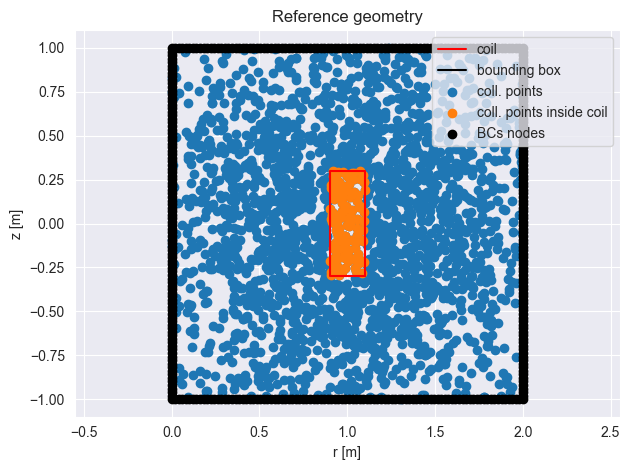

In [12]:
## Collocation points: uniform spreading:
n_coll = 3000
np.random.seed(42)
# coll_pts = np.random.random(size=(n_coll,2))*(box.max(axis=0) - box.min(axis=0)) + box.min(axis=0)
coll_pts = np.random.normal(size=(n_coll,2), loc = coil_center, scale=(.65,.65))#*(box.max(axis=0) - box.min(axis=0)) + box.min(axis=0)

p = path.Path(box[:-1,:])
mask = p.contains_points(coll_pts)
coll_pts = coll_pts[mask,...]


## Collocation points inside the source
p = path.Path(coil[:-1,:])
mask = p.contains_points(coll_pts)

## BCs points
n_edge = 100 #number of points for each edge of the boundary
xx = np.linspace(0,1,n_edge).reshape(-1,1)*(box[:,0].max() - box[:,0].min()) + box[:,0].min()
yy = np.linspace(0,1,n_edge).reshape(-1,1)*(box[:,1].max() - box[:,1].min()) + box[:,1].min()
BCs_pts = np.column_stack((
    np.row_stack((xx,0*xx+xx[-1], np.flipud(xx), 0*xx+xx[0])),
    np.row_stack((0*yy+yy[0], yy, 0*yy+yy[-1], np.flipud(yy)))
))
BCs_pts = np.unique(BCs_pts,axis=0)

plt.figure()
plt.plot(coil[:,0],coil[:,1], c='r', label='coil')
plt.plot(box[:,0],box[:,1], c='k',label='bounding box')
plt.scatter(coll_pts[:,0],coll_pts[:,1], marker='o', label='coll. points')
plt.scatter(coll_pts[mask,0],coll_pts[mask,1], marker='o', label='coll. points inside coil')
plt.scatter(BCs_pts[:,0],BCs_pts[:,1], color='k', label = 'BCs nodes')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.axis('equal')
plt.legend()
plt.title('Reference geometry')
plt.tight_layout()
# plt.show()
plt.savefig('figures/geo_coll_pts.png', dpi=200)

0/0


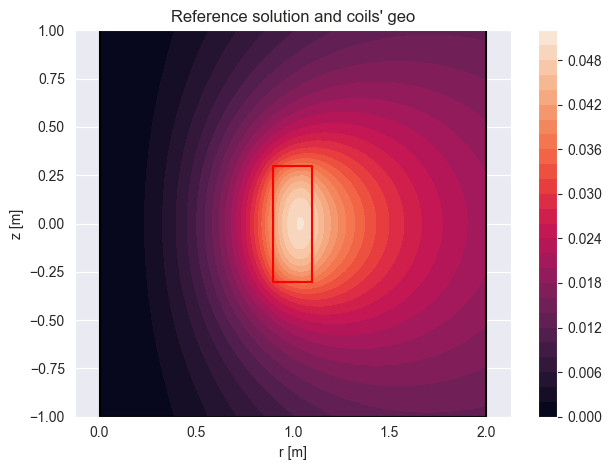

In [13]:
from IETy.funEquil import fun_Field_Coil

source = {}
source['R'] = [coil_center[0]]
source['Z'] = [coil_center[1]]
source['DR'] = [delta_r]
source['DZ'] = [delta_z]

points = {}
points['R'] = RR.reshape(-1,1)
points['Z'] = ZZ.reshape(-1,1)

res_a,res_br,res_bz,res_psi = fun_Field_Coil(
    source, 
    points, 
    NGauss = 10
    )

J = 1e+6
# J=1
Area = delta_r*delta_z
I = J*Area
psi_grid = res_psi*I/2/np.pi

# print(np.mean(J_source)*delta_r*delta_z)
# print(np.mean(J_source)*delta_r*delta_z)

plt.figure()
plt.contourf(RR,ZZ,psi_grid.reshape(RR.shape),30)
plt.plot(coil[:,0],coil[:,1], c='r', label='coil')
plt.plot(box[:,0],box[:,1], c='k',label='bounding box')
plt.axis('equal')
plt.colorbar()
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.title('Reference solution and coils\' geo')
# plt.show()
plt.tight_layout()
plt.savefig('figures/reference_sol.png', dpi=200)

In [14]:
source = {}
source['R'] = [coil_center[0]]
source['Z'] = [coil_center[1]]
source['DR'] = [delta_r]
source['DZ'] = [delta_z]

points = {}
points['R'] = BCs_pts[:,0].reshape(-1,1)
points['Z'] = BCs_pts[:,1].reshape(-1,1)
res_a,res_br,res_bz,res_psi = fun_Field_Coil(
    source, 
    points, 
    NGauss = 10
    )
psi_BCs = res_psi*I/2/np.pi

print(psi_BCs.max())

points = {}
points['R'] = coll_pts[:,0].reshape(-1,1)
points['Z'] = coll_pts[:,1].reshape(-1,1)
res_a,res_br,res_bz,res_psi = fun_Field_Coil(
    source, 
    points, 
    NGauss = 10
    )
psi_coll_pts = res_psi*I/2/np.pi
print(psi_coll_pts.max())




J_source = np.zeros_like(coll_pts[:,0])
J_source[mask] = J
# Set data type for TensorFlow
DTYPE='float32'
# tf.keras.backend.set_floatx(DTYPE)

X_r    = tf.constant(coll_pts, dtype=DTYPE)  # -> collocation points
X_train = tf.constant(BCs_pts, dtype=DTYPE)   # -> boundary points
y_train = tf.constant(psi_BCs, dtype=DTYPE)  #-> values of function at boundary points
J_source = tf.constant(J_source.ravel(),dtype=DTYPE)


mu0 = np.float32(4*np.pi*1e-7)
fac_scale = np.sum(psi_BCs.reshape(-1,1))/np.sum(mu0*J_source*coll_pts[:,0].reshape(-1,1))/np.pi
coll_pts = tf.constant(coll_pts,dtype=DTYPE)

n_input = 2
n_output = 1

print('No of collocation points = ', X_r.shape[0])
print('No of boundary points    = ', X_train.shape[0])

0/0
0.020714486881623063
0/0
0.0500380764460549


2024-04-09 14:12:47.685710: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-09 14:12:47.685746: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-09 14:12:47.685757: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-09 14:12:47.686120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 14:12:47.686419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


No of collocation points =  2288
No of boundary points    =  396


Define the input/output for training the the Deep Neural Network (DNN), i.e., `X_train` are the $(x,y)$ coordinates of the boundary points and `y_train` are the values of the function at these points. Moreover, we define also `X_r`, the vector of the $(x,y)$ coordinates of the collocation points.

Define the architecture of the Neural Network.

In [15]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):

    def __init__(self,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 batch_normalization = False,
                 **kwargs):
        super().__init__(**kwargs)
        # define all layers in init
        # Layer of Block 1
        
        
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        self.hidden = []
        for _ in range(num_hidden_layers):
            if batch_normalization: 
                self.hidden.append(tf.keras.layers.BatchNormalization())
            self.hidden.append(tf.keras.layers.Dense(num_neurons_per_layer,
                                                     activation=activation,
                                                     kernel_initializer=kernel_initializer))

        self.out = tf.keras.layers.Dense(output_dim)

        self.hist = []
        self.iter = 0

    def call(self, X, training=False):
        Z = X
        for i in range(len(self.hidden)):
            Z = self.hidden[i](Z)
        return self.out(Z)
    



Now define the solver architecture. Note that all the following methods can be merged in the previous `PINN_NeuralNet` class, rather than defining a solver. Now initialize the `PINN_NeuralNet` model and the `PINN_solver`. Train the network. Here `fac_scale_loss` is chosen to scale the PDE equation, to avoid overshoots.

In [16]:
class PINN_solver():
    def __init__(self, 
                 model, 
                 coll_pts = np.zeros((2,2))):
        self.model = model
        
        # (x,y) of the collocation points (where PDE is enforced)
        # coll_pts = tf.constant(coll_pts)
        self.x = coll_pts[:,0]
        self.y = coll_pts[:,1]
        
        # for history and display callbacks
        self.hist = []
        self.hist_DNN = []
        self.hist_PDE = []
        self.iter = 0
        
    
    def display_callback(self, print_status_every_N_epochs = 50):
        ''' print loss on command window '''
        if self.iter % print_status_every_N_epochs == 0:
            print('epoch {:05d}: loss = {:10.8e}'.format(self.iter,self.train_loss))
            
    def display_during_training_callback(self):
        if self.epoch == 0:
            self.figure, self.ax = plt.subplots()
            plt.xlabel("epochs")
            plt.ylabel("cost")
            self.plot1 = self.ax.plot(range(self.epoch), self.hist)[0]
        else:
            self.plot1 = plt.plot(self.hist[self.epoch-1:self.epoch], '-')
            
            
    def history_callback(self):
        ''' stores loss history '''
        self.hist.append(self.train_loss)
        self.hist_DNN.append(self.train_loss_DNN)
        self.hist_PDE.append(self.train_loss_PDE)
        self.iter+=1
        
        
    def plot_history(self):
        ''' stores loss history '''
        plt.figure()
        plt.plot(self.hist, '-')
        plt.yscale('log')
        plt.title('Training history')
        plt.xlabel('epochs')
        plt.ylabel('loss')        
    
    
    def fun_r_MagnetoStatic_Axi_psi(self):
        """Residual of the PDE"""
        self = self.get_derivatives()
        jphi = J_source
        res = self.u_xx + self.u_yy - self.u_x/self.x + mu0*jphi*self.x
        return res
    
    
    def get_derivatives(self):
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                u = self.model(tf.stack([x, y], axis=1))
            u_x = gg.gradient(u, x)  
        u_xx = g.gradient(u_x, x) 
        del g, gg
        
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(y)
            with tf.GradientTape(persistent=False) as gg:
                gg.watch(y)
                u = self.model(tf.stack([x, y], axis=1))
            u_y = gg.gradient(u, y)  
        u_yy = g.gradient(u_y, y) 
        del g, gg 
        
        self.u_x = u_x
        self.u_xx = u_xx
        self.u_y = u_y
        self.u_yy = u_yy
        return self 
    
        
    def loss_fun_PDE(self, y_ds, prediction,fac_scale_loss): #model, X_r, X_data, u_data):
        loss_PDE = tf.reduce_mean(tf.square(self.fun_r_MagnetoStatic_Axi_psi()))
        loss_DNN = tf.reduce_mean(tf.square(y_ds - prediction))
        
        loss_PDE = loss_PDE*fac_scale_loss
        loss = loss_DNN + loss_PDE
        return loss, loss_DNN, loss_PDE    
     
    
    ''' .fit method '''    
    def fit(
            self,
            X_train,
            y_train,
            fac_scale_loss = 1,
            optimizer=tf.keras.optimizers.Adam(),
            epochs=50,
            batch_size=32,
            verbose=True, 
            print_status_every_N_epochs = 50,
            display_during_training = False):
        ''' implement standard fit method via sub-classing'''


        @tf.function
        def train_step(x_ds,y_ds):
            with tf.GradientTape() as tape:
                predictions = self.model(x_ds, training=False)
                loss, loss_DNN, loss_PDE = self.loss_fun_PDE(y_ds, predictions,fac_scale_loss)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                        
            train_loss     = tf.reduce_mean(loss)
            train_loss_DNN = tf.reduce_mean(loss_DNN)
            train_loss_PDE = tf.reduce_mean(loss_PDE)
            return train_loss, train_loss_DNN, train_loss_PDE
        
    
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(batch_size)
        p = tqdm(range(epochs),miniters=1)
        for epoch in p:
            self.epoch = epoch
            for x_ds, y_ds in train_ds:
                loss, loss_DNN, loss_PDE = train_step(x_ds, y_ds)
                # predictions = self.model(x_ds)
                # print(predictions.numpy().max(),y_ds.numpy().max())
            # p.set_description('epoch {:05d}: loss = {:10.8e}'.format(epoch,loss))
            p.set_postfix({'epoch': epoch, 'loss' : loss.numpy()})
                
            ###
            self.train_loss = loss.numpy()
            self.train_loss_DNN = loss_DNN.numpy()
            self.train_loss_PDE = loss_PDE.numpy()
            
            # if verbose:
            #     self.display_callback(print_status_every_N_epochs = print_status_every_N_epochs)
                
            if display_during_training:
                self.display_during_training_callback()
                
            self.history_callback()


Starting training with epochs = 250


100%|██████████| 250/250 [03:21<00:00,  1.24it/s, epoch=249, loss=0.000755]


203.60693907737732


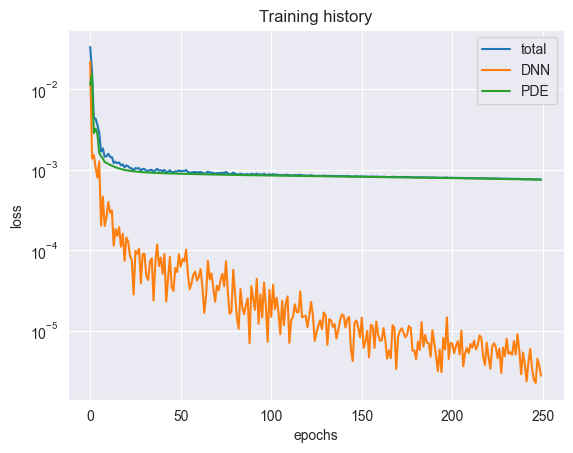

In [22]:
# if platform.processor() == 'arm':       
#     optimizer = tf.keras.optimizers.legacy.Adam()
# else:
optimizer = tf.keras.optimizers.Adam()

sub_classing_model = PINN_NeuralNet(
    output_dim=n_output,
    num_hidden_layers=8,
    num_neurons_per_layer=20,
    activation='swish',
    kernel_initializer='he_normal',
    batch_normalization=False)


solver = PINN_solver(sub_classing_model, coll_pts)


fac_scale_loss = .01
# fac_scale_loss = 1

batch_size = 64
epochs = 250
print('Starting training with epochs =', epochs)
t_start = time()
solver.fit(
    X_train,
    y_train,
    fac_scale_loss = fac_scale_loss,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    # print_status_every_N_epochs = 1000
    )
t_end = time()
print(t_end - t_start)


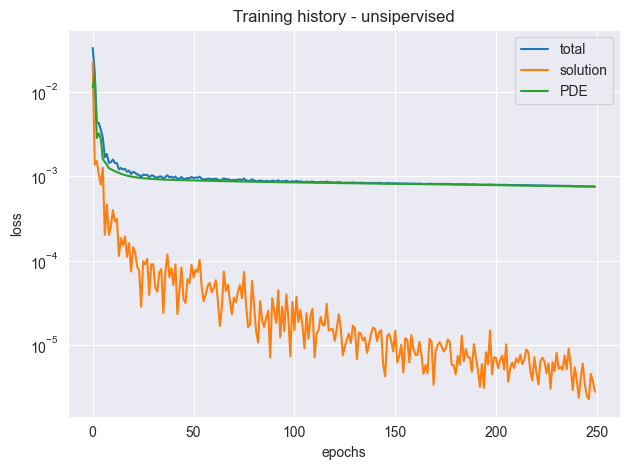

In [25]:
plt.figure()
plt.plot(solver.hist, '-', label = 'total')
plt.plot(solver.hist_DNN, '-', label = 'solution')
plt.plot(solver.hist_PDE, '-', label = 'PDE')
plt.yscale('log')
plt.title('Training history - unsipervised')
plt.xlabel('epochs')
plt.ylabel('loss')       
plt.legend()# plt.show()
plt.tight_layout()
plt.savefig('figures/history_unsupervised.png', dpi=200)

Plot training history.

Test the model.

In [26]:
X_test = X_r
sol_PINN = sub_classing_model.predict(X_test)

print(psi_coll_pts.max())
print(sol_PINN.max())

72/72 [==============================] - 1s 5ms/step
0.0500380764460549
0.030625854


In [27]:
sol_PINN = sub_classing_model.predict(X_train)
sol_PINN.max()

13/13 [==============================] - 0s 10ms/step


0.023925576

313/313 [==============================] - 1s 3ms/step


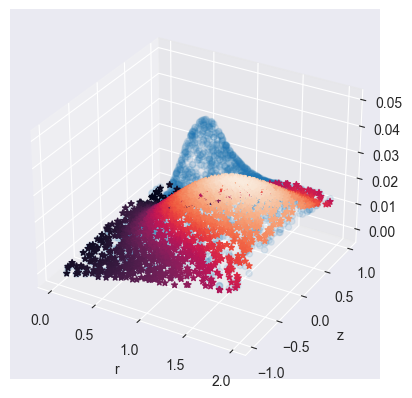

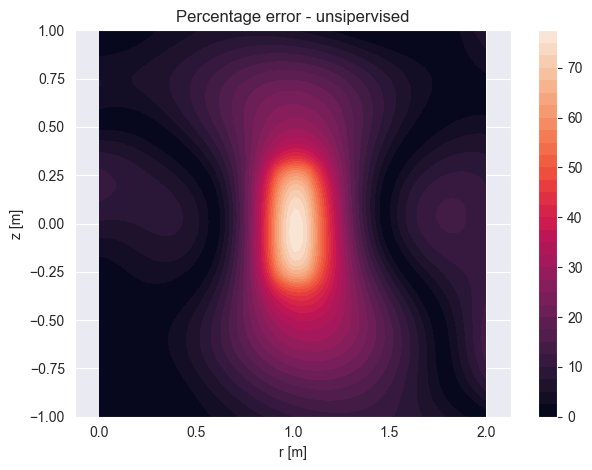

In [28]:
# test the model on the collocation points
X_test = X_r

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_coll_pts

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)
ax.set_xlabel("r")
ax.set_ylabel("z")


# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = res_psi

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    100*abs(sol_PINN - psi_grid.reshape(-1, 1)), X_grid.shape)/max(np.abs(sol_PINN)), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Percentage error - unsipervised')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
# plt.show()
plt.tight_layout()
plt.savefig('figures/percentage_error_unsupervised.png', dpi=200)

313/313 [==============================] - 1s 2ms/step
0.05009507971005776
0.048638836


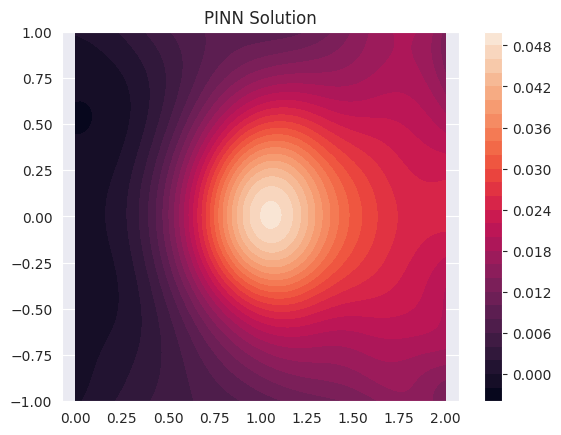

In [40]:
# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_grid

print(sol_ref.max())
print(sol_PINN.max())

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    sol_PINN, X_grid.shape), 30)
plt.axis('equal')
plt.colorbar()
plt.title('PINN Solution')
plt.xlabel('r [m]')
plt.ylabel('z [m]')
# plt.show()
plt.tight_layout()
plt.savefig('figures/PINN_sol_unsupervised.png', dpi=200)

In [41]:
### # Set data type for TensorFlow
tf.keras.backend.set_floatx(DTYPE)

X_r    = tf.constant(coll_pts, dtype=DTYPE)  # -> collocation points
X_train = tf.constant(np.row_stack((
    coll_pts, BCs_pts)), dtype=DTYPE)   # -> boundary points
y_train = tf.constant(np.row_stack((psi_coll_pts,psi_BCs)), dtype=DTYPE)  #-> values of function at boundary points
# J_source = tf.constant(J_source.ravel(),dtype=DTYPE)

n_input = 2
n_output = 1

print('No of collocation points = ', X_r.shape[0])
print('No of boundary points    = ', X_train.shape[0])

No of collocation points =  2288
No of boundary points    =  2684


313/313 [==============================] - 1s 2ms/step


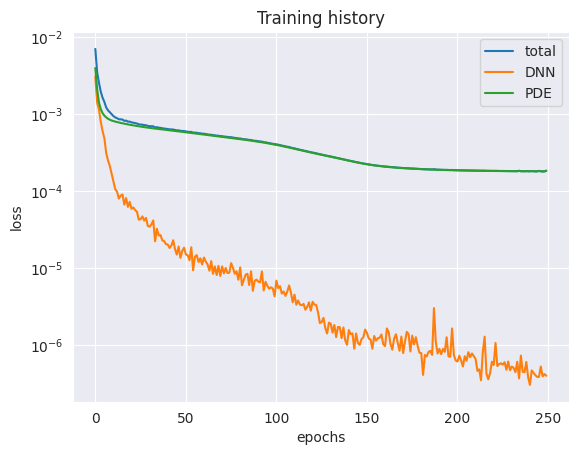

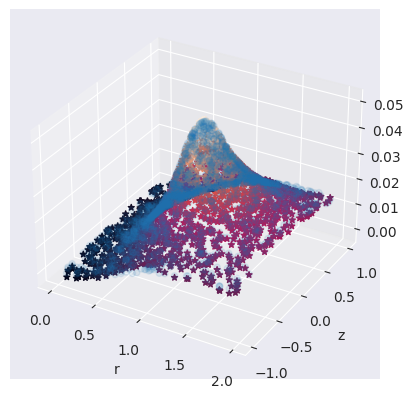

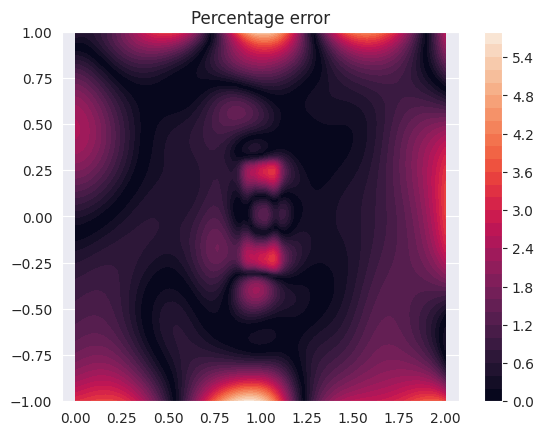

313/313 [==============================] - 1s 2ms/step


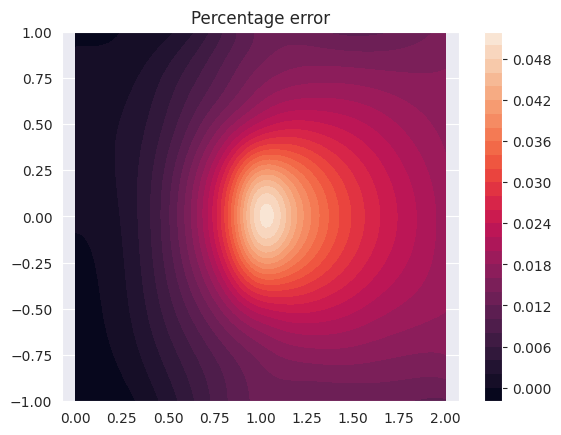

In [43]:
sub_classing_model = PINN_NeuralNet(
    output_dim=n_output,
    num_hidden_layers=8,
    num_neurons_per_layer=20,
    activation='swish',
    kernel_initializer='he_normal',
    batch_normalization=False)


solver = PINN_solver(sub_classing_model, coll_pts)


fac_scale_loss = .01
# fac_scale_loss = .1

batch_size = 128
epochs = 250
print('Starting training with epochs =', epochs)
t_start = time()
solver.fit(
    X_train,
    y_train,
    fac_scale_loss = fac_scale_loss,
    optimizer=tf.keras.optimizers.Adam(),
    epochs=epochs,
    batch_size=batch_size,
    # print_status_every_N_epochs = 25
    )
t_end = time()
print(t_end - t_start)

plt.figure()
plt.plot(solver.hist, '-', label = 'total')
plt.plot(solver.hist_DNN, '-', label = 'DNN')
plt.plot(solver.hist_PDE, '-', label = 'PDE')
plt.yscale('log')
plt.title('Training history')
plt.xlabel('epochs')
plt.ylabel('loss')       
plt.legend()



# test the model on the collocation points
X_test = X_r

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_coll_pts

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)
ax.set_xlabel("r")
ax.set_ylabel("z")


# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = psi_grid

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    100*abs(sol_PINN - sol_ref.reshape(-1, 1)), X_grid.shape)/max(np.abs(sol_PINN)), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Percentage error - supervised')
plt.show()
plt.xlabel('r [m]')
plt.ylabel('z [m]')
# plt.show()
plt.tight_layout()
plt.savefig('figures/PINN_sol_unsupervised.png', dpi=200)

# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = res_psi

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    sol_PINN, X_grid.shape), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Percentage error')
plt.show()

313/313 [==============================] - 1s 2ms/step


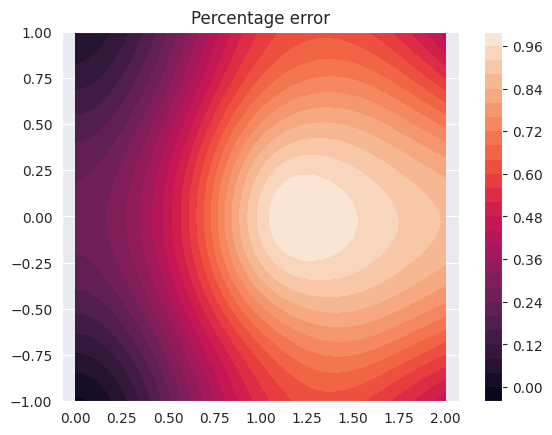

In [202]:
# test the model on ta new set of points
X_grid, Y_grid = RR,ZZ
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = res_psi

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    sol_PINN, X_grid.shape)/max(np.abs(sol_PINN)), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Percentage error')
plt.show()